# Water Quality Classification Analysis

# Imports

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA


# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN

# K Best columns
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

# Functions

In [53]:
def check_for_dupes_nans(df:pd.DataFrame):
    """
    Checks for dupes and nulls
    """
    amount_of_dupes = df.duplicated().sum()
    print(f"Null Count: {df.isna().sum()}")
    print(f"Dupe Count: {amount_of_dupes}")

def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  
  ax = df[col].value_counts().sort_index().plot(
  kind="bar", 
  title="Count of Reviews by Target", 
  figsize=(10,5)
  )
  ax.set_xlabel(col)
  plt.show()

def create_pipeline(preprocessor, features):
  return preprocessor.fit_transform(features)

def evaluate_model(X:pd.Series, y:pd.Series, model):
    """
    This function takes in X, y values
    scores model performance based on
    subsets of data

    Returns:
        scores of models
    """
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    
    metric = make_scorer(f1_score)
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        scores = evaluate_model(X, y, model)
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)
  
def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "MN": MultinomialNB()
  }
  
  return [models[model] for model in names]

def get_over_sampling_methods(X, y, name):
  
  sampling_models = {
    "KNN-SMOTE":SMOTE(k_neighbors=5, random_state=42),
    "BL-SMOTE": BorderlineSMOTE(kind='borderline-1', random_state=42),
    "SMOTE": SMOTE(),
    "ADASYN": ADASYN(random_state=42)
  }
  
  sampling_model = sampling_models[name]
  X_res, y_res = sampling_model.fit_resample(X, y)
  
  return (X_res, y_res)


# EDA Analysis

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/water.csv")
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


# Check For Nulls and Dupes

In [4]:
check_for_dupes_nans(df)

Null Count: ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64
Dupe Count: 0


# We will have to fill Null values with either the mean or the median depending on the distribution

# Check For Class Imbalance

Class=0, Count=1998, Percentage=60.989%
Class=1, Count=1278, Percentage=39.011%


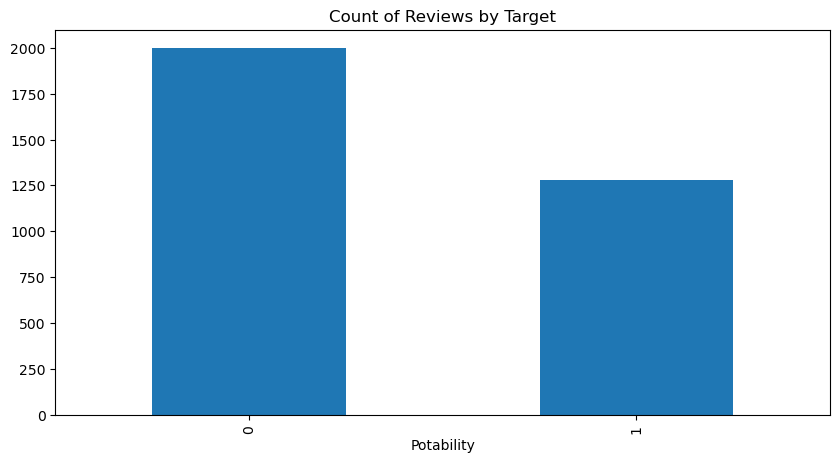

In [5]:
check_class_imbalance(df,df['Potability'], 'Potability')

# Somewhat imbalanced dataset, we might need to use sampling methods. We will have to check.

In [6]:
df.dtypes

ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Potability           int64
dtype: object

In [7]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


# PH Column is normally distributed given the std but lets plot this and see for ourselves

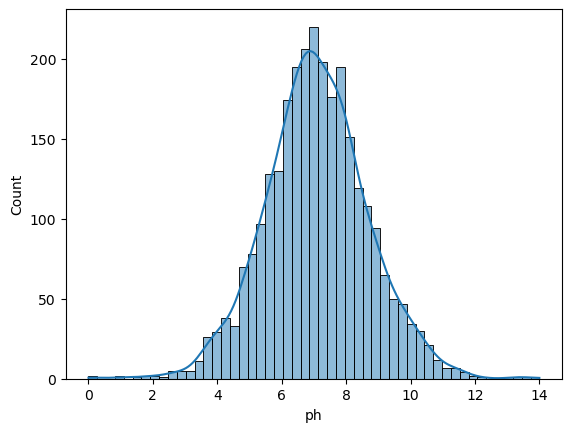

In [8]:
sns.histplot(df['ph'], kde=True)
plt.show()

# Sulfate seems skewed, lets see.

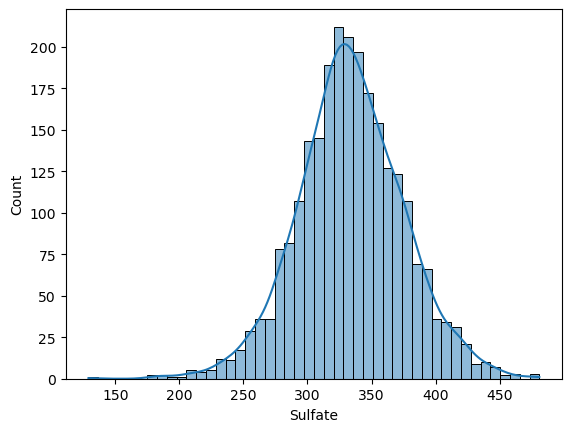

Skewness: -0.03594662160705805


In [11]:
sns.histplot(df['Sulfate'], kde=True)
plt.show()

skewness = df['Sulfate'].skew()
print(f"Skewness: {skewness}")

# Slightly negative skew for Trihalomethanes

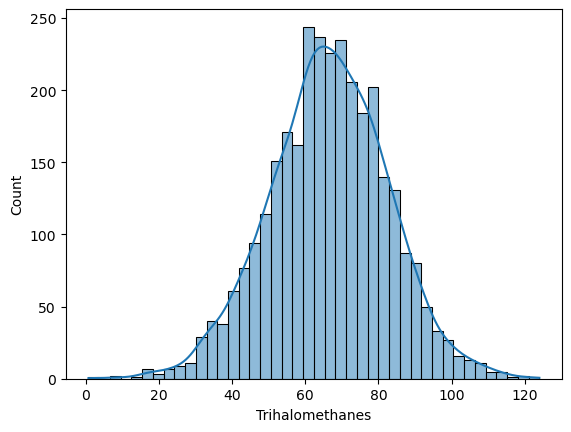

Skewness: -0.08303067407901556


In [12]:
sns.histplot(df['Trihalomethanes'], kde=True)
plt.show()

skewness = df['Trihalomethanes'].skew()
print(f"Skewness: {skewness}")

# Give the skew is negative but minimal, the mean would be a good choice here to use to fill in null values

# Separate Feature Variables

In [16]:
X,y = df.drop("Potability", axis=1), df["Potability"]

# Create Preprocessor

In [48]:
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ("power_transformer", PowerTransformer())
])

X = create_pipeline(preprocessor, X)

# Baseline Model

In [49]:
model = DummyClassifier(strategy="uniform")
scores = evaluate_model(X, y, model)
print(f"Mean: {round(np.mean(scores),3)}, STD: {round(np.std(scores),3)}")

Mean: 0.438, STD: 0.021


# Advanced Model Metrics

In [50]:
names = ['LR', 'SVC']
models = get_selected_models(names)
testing_selected_models(names, models, X, y)

,Model,Mean,STD
1,SVC,0.418838,0.026830
0,LR,0.003107,0.004742


In [51]:
names = ["RFC", "DTC", "GBC", "XGB"]
models = get_selected_models(names)
testing_selected_models(names, models, X, y)

,Model,Mean,STD
1,DTC,0.477809,0.023535
3,XGB,0.469307,0.020640
0,RFC,0.445506,0.026639
2,GBC,0.358639,0.025134


# We may need to test sampling methods as the model is performing poorly

# SMOTE Method